In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-activity-recognition-with-smartphones/train.csv
/kaggle/input/human-activity-recognition-with-smartphones/test.csv


**Import Libraries**

In [2]:
# To store data
import pandas as pd

# To do linear algebra
import numpy as np
from numpy import pi

# To create plots
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

# To create nicer plots
import seaborn as sns

# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To get new datatypes and functions
from collections import Counter
from cycler import cycler

# To investigate distributions
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

# To build models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# To gbm light
from lightgbm import LGBMClassifier

# To measure time
from time import time

**Load Data**

In [3]:
# Load datasets
train_df = pd.read_csv('../input/human-activity-recognition-with-smartphones/train.csv')
test_df = pd.read_csv('../input/human-activity-recognition-with-smartphones/test.csv')

# Combine boths dataframes
train_df['Data'] = 'Train'
test_df['Data'] = 'Test'
both_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
both_df['subject'] = '#' + both_df['subject'].astype(str)

# Create label
label = both_df.pop('Activity')

print('Shape Train:\t{}'.format(train_df.shape))
print('Shape Test:\t{}\n'.format(test_df.shape))

train_df.head()

Shape Train:	(7352, 564)
Shape Test:	(2947, 564)



,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING,Train
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING,Train
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING,Train


**Dataset Exploration**

In [4]:
# Group and count main names of columns
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in both_df.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


Mainly there are 'acceleration' and 'gyroscope' features. A few 'gravity' features are there as well.

Impressive how many features there are in regard of the limited number of sensors used.

In [5]:
# Get null values and dataframe information
print('Null Values In DataFrame: {}\n'.format(both_df.isna().sum().sum()))
both_df.info()

Null Values In DataFrame: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 563 entries, tBodyAcc-mean()-X to Data
dtypes: float64(561), object(2)
memory usage: 44.2+ MB


**Distribution of Labels**

In [6]:
# Plotting data
label_counts = label.value_counts()

# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Create plot
data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone Activity Label Distribution',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

Disregarding the possibility of flawed data, the participants seem to walk roughly 10% faster downwards.

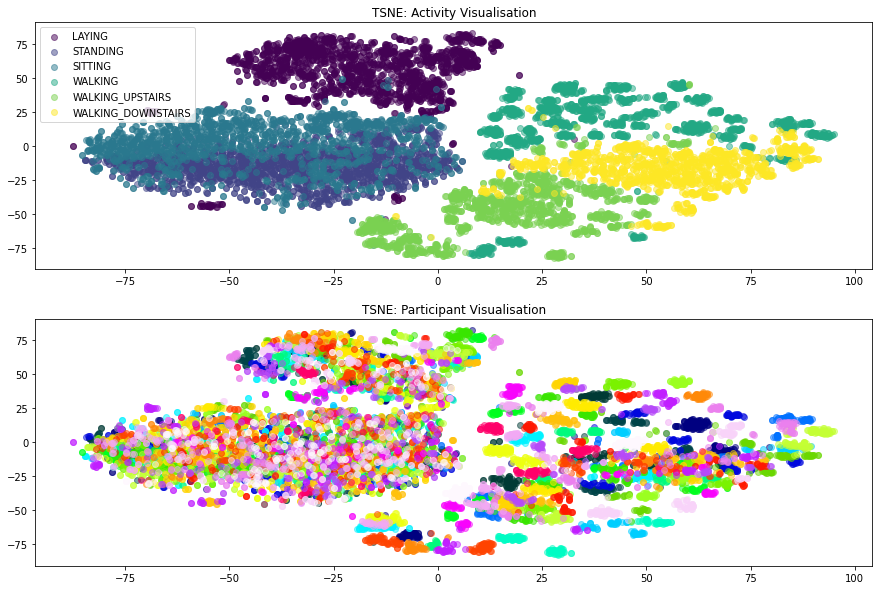

In [7]:
# Create datasets
tsne_data = both_df.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
fig, axarr = plt.subplots(2, 1, figsize=(15,10))

### Plot Activities
# Get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    axarr[0].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('TSNE: Activity Visualisation')
axarr[0].legend()


### Plot Subjects
# Get colors
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each participant
for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()

**Plot-1: Activities are mostly separable.**

**Plot-2: Personal Information of the participants are visualised.**

In [8]:
# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(label)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=3)

# Create the model
lgbm = LGBMClassifier(n_estimators=500, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

# Test the model
score = accuracy_score(y_true=y_test, y_pred=lgbm.predict(X_test))
print('Accuracy on testset:\t{:.4f}\n'.format(score))

Accuracy on testset:	0.9553



**The separability of the participants seems to dissent concerning their activity in second t-SNE plots.**

In [9]:
# Store the data
data = []
# Iterate over each activity
for activity in label_counts.index:
    # Create dataset
    act_data = both_df[label==activity].copy()
    act_data_data = act_data.pop('Data')
    act_subject_data = act_data.pop('subject')
    
    # Scale data
    scl = StandardScaler()
    act_data = scl.fit_transform(act_data)

    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    act_data = pca.fit_transform(act_data)

    
    # Split training testing data
    enc = LabelEncoder()
    label_encoded = enc.fit_transform(act_subject_data)
    X_train, X_test, y_train, y_test = train_test_split(act_data, label_encoded, random_state=3)


    # Fit basic model
    print('Activity: {}'.format(activity))
    lgbm = LGBMClassifier(n_estimators=500, random_state=3)
    lgbm = lgbm.fit(X_train, y_train)
    
    score = accuracy_score(y_true=y_test, y_pred=lgbm.predict(X_test))
    print('Accuracy on testset:\t{:.4f}\n'.format(score))
    data.append([activity, score])

Activity: LAYING
Accuracy on testset:	0.6481

Activity: STANDING
Accuracy on testset:	0.5493

Activity: SITTING
Accuracy on testset:	0.5303

Activity: WALKING
Accuracy on testset:	0.9513

Activity: WALKING_UPSTAIRS
Accuracy on testset:	0.9249

Activity: WALKING_DOWNSTAIRS
Accuracy on testset:	0.9091



In [10]:
# Create duration datafrae
duration_df = (both_df.groupby([label, subject_data])['Data'].count().reset_index().groupby('Activity').agg({'Data':'mean'}) * 1.28).rename(columns={'Data':'Seconds'})
activity_df = pd.DataFrame(data, columns=['Activity', 'Accuracy']).set_index('Activity')
activity_df.join(duration_df)

,Accuracy,Seconds
Activity,,
LAYING,0.648148,82.944000
STANDING,0.549266,81.322667
SITTING,0.530337,75.818667
WALKING,0.951276,73.472000
WALKING_UPSTAIRS,0.924870,65.877333
WALKING_DOWNSTAIRS,0.909091,59.989333


**Visualizations for feature distributions**

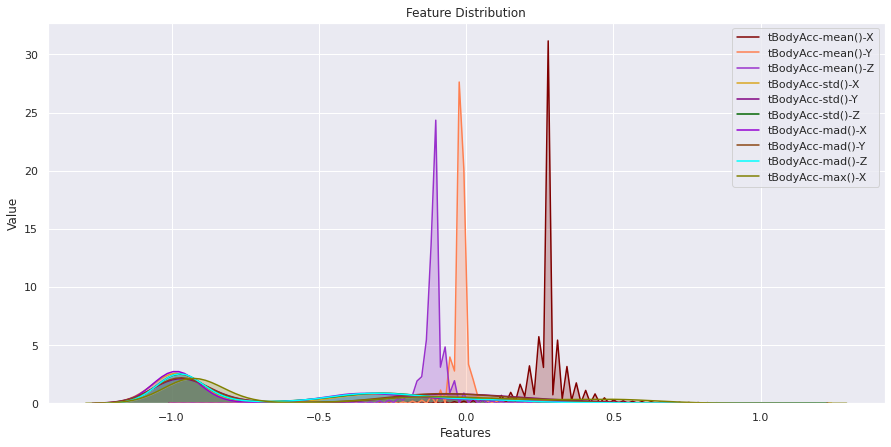

In [11]:
sns.set(rc={'figure.figsize':(15,7)})
colours = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in train_df.columns[0:10]:
    index = index + 1
    fig = sns.kdeplot(train_df[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

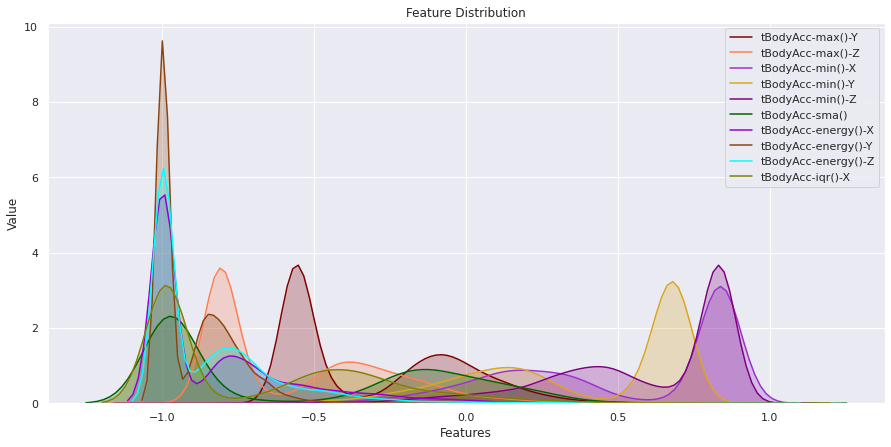

In [12]:
sns.set(rc={'figure.figsize':(15,7)})
colours = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in train_df.columns[10:20]:
    index = index + 1
    ax1 = sns.kdeplot(train_df[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

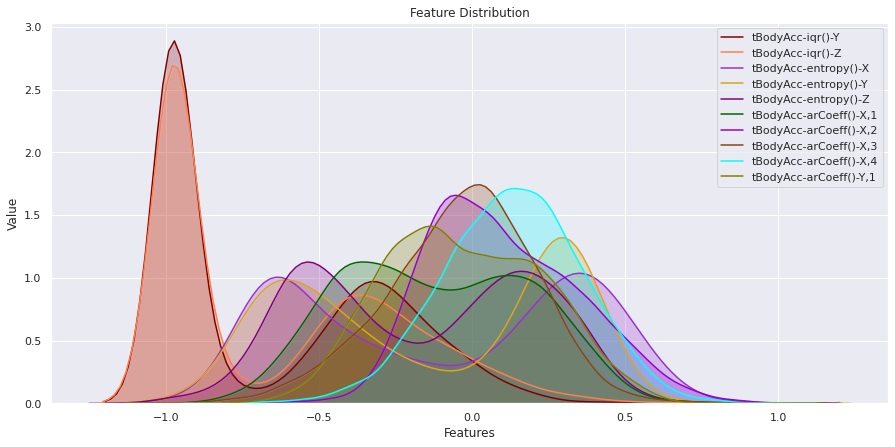

In [13]:
sns.set(rc={'figure.figsize':(15,7)})
colours = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in train_df.columns[20:30]:
    index = index + 1
    ax1 = sns.kdeplot(train_df[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

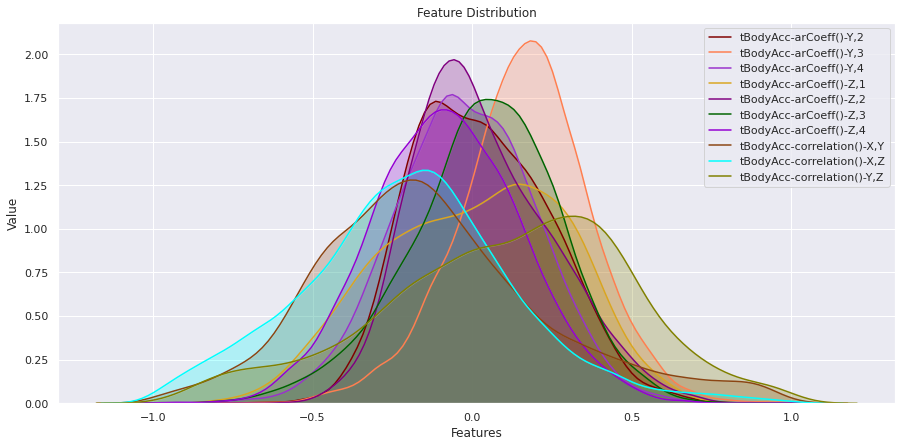

In [14]:
sns.set(rc={'figure.figsize':(15,7)})
colours = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in train_df.columns[30:40]:
    index = index + 1
    ax1 = sns.kdeplot(train_df[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

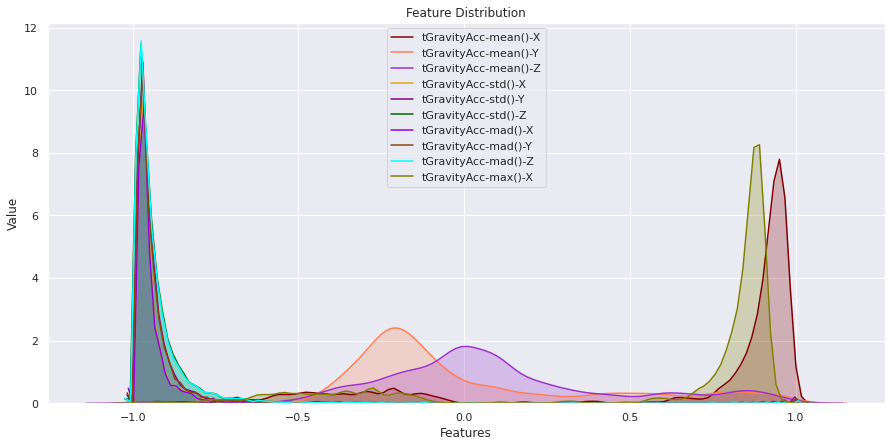

In [15]:
sns.set(rc={'figure.figsize':(15,7)})
colours = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive"]
index = -1
for i in train_df.columns[40:50]:
    index = index + 1
    ax1 = sns.kdeplot(train_df[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig)

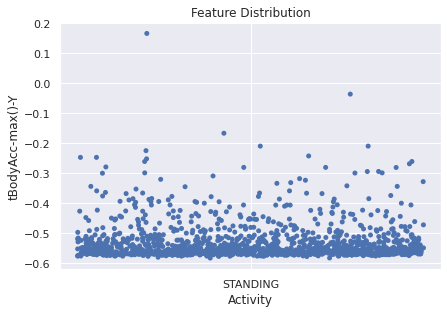

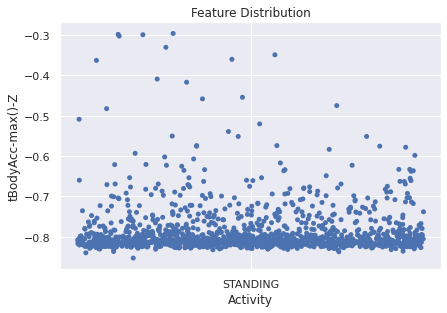

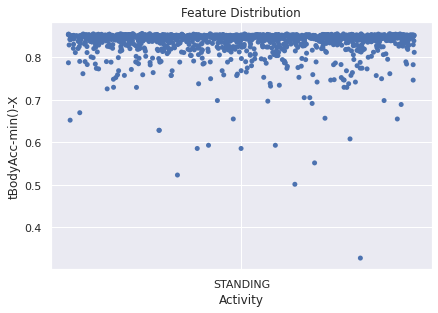

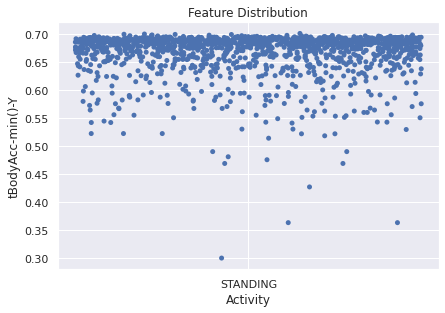

In [16]:
sns.set(rc={'figure.figsize':(15,10)})
plt.subplot(221)
fig1 = sns.stripplot(x='Activity', y= train_df.loc[train_df['Activity']=="STANDING"].iloc[:,10], data= train_df.loc[train_df['Activity']=="STANDING"], jitter=True)
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig1)
plt.subplot(224)
fig2 = sns.stripplot(x='Activity', y= train_df.loc[train_df['Activity']=="STANDING"].iloc[:,11], data= train_df.loc[train_df['Activity']=="STANDING"], jitter=True)
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig2)
plt.subplot(223)
fig2 = sns.stripplot(x='Activity', y= train_df.loc[train_df['Activity']=="STANDING"].iloc[:,12], data= train_df.loc[train_df['Activity']=="STANDING"], jitter=True)
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig2)
plt.subplot(222)
fig2 = sns.stripplot(x='Activity', y= train_df.loc[train_df['Activity']=="STANDING"].iloc[:,13], data= train_df.loc[train_df['Activity']=="STANDING"], jitter=True)
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig2)

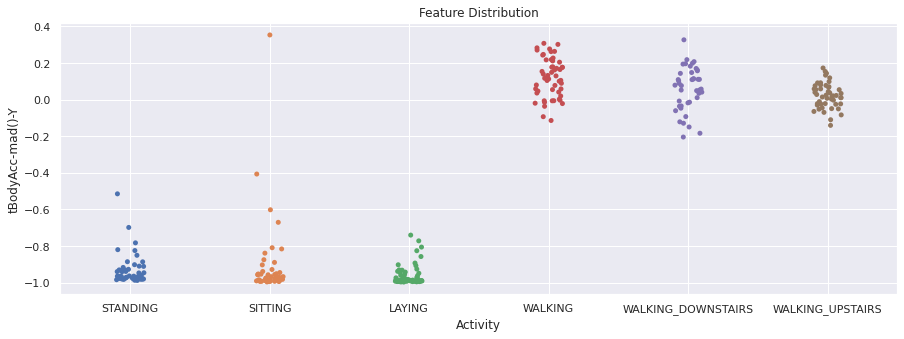

In [17]:
sns.set(rc={'figure.figsize':(15,5)})
fig1 = sns.stripplot(x='Activity', y= train_df.loc[train_df['subject']==15].iloc[:,7], data= train_df.loc[train_df['subject']==15], jitter=True)
plt.title("Feature Distribution")
plt.grid(True)
plt.show(fig1)

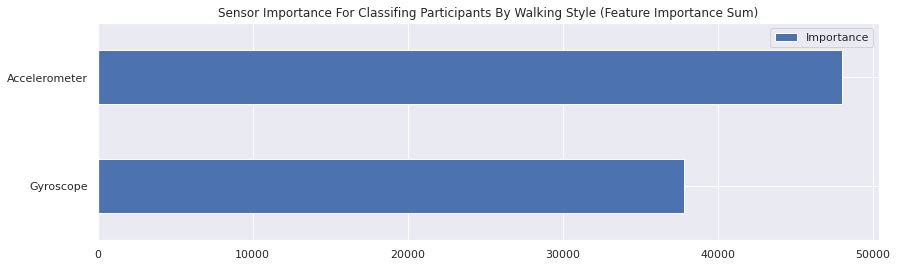

In [18]:
# Create dataset
tsne_data = both_df[label=='WALKING'].copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(subject_data)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=3)


# Create model
lgbm = LGBMClassifier(n_estimators=500, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

# Get importances
features = both_df.drop(['Data', 'subject'], axis=1).columns
importances = lgbm.feature_importances_

# Sum importances
data = {'Gyroscope':0, 'Accelerometer':0}
for importance, feature in zip(importances, features):
    if 'Gyro' in feature:
        data['Gyroscope'] += importance
    if 'Acc' in feature:
        data['Accelerometer'] += importance
        
# Create dataframe and plot
sensor_df = pd.DataFrame.from_dict(data, orient='index').rename(columns={0:'Importance'})
sensor_df.plot(kind='barh', figsize=(14,4), title='Sensor Importance For Classifing Participants By Walking Style (Feature Importance Sum)')
plt.show()

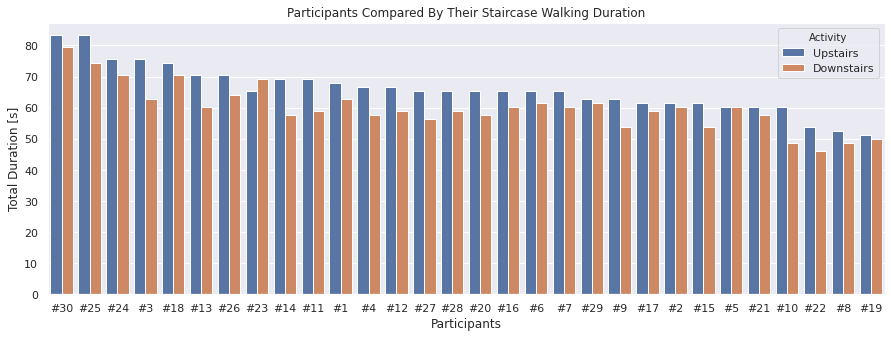

In [19]:
# Group the data by participant and compute total duration of staircase walking
mask = label.isin(['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])
duration_df = (both_df[mask].groupby([label[mask], 'subject'])['Data'].count() * 1.28)

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending=False)
plot_data['Activity'] = plot_data['Activity'].map({'WALKING_UPSTAIRS':'Upstairs', 'WALKING_DOWNSTAIRS':'Downstairs'})

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data', hue='Activity')
plt.title('Participants Compared By Their Staircase Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

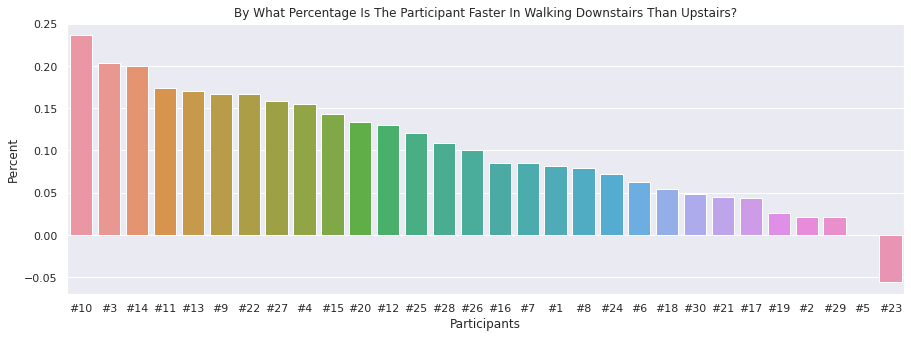

In [20]:
# Create data and plot
plt.figure(figsize=(15,5))
plot_data = ((duration_df.loc['WALKING_UPSTAIRS'] / duration_df.loc['WALKING_DOWNSTAIRS']) -1).sort_values(ascending=False)
sns.barplot(x=plot_data.index, y=plot_data)
plt.title('By What Percentage Is The Participant Faster In Walking Downstairs Than Upstairs?')
plt.xlabel('Participants')
plt.ylabel('Percent')
plt.show()

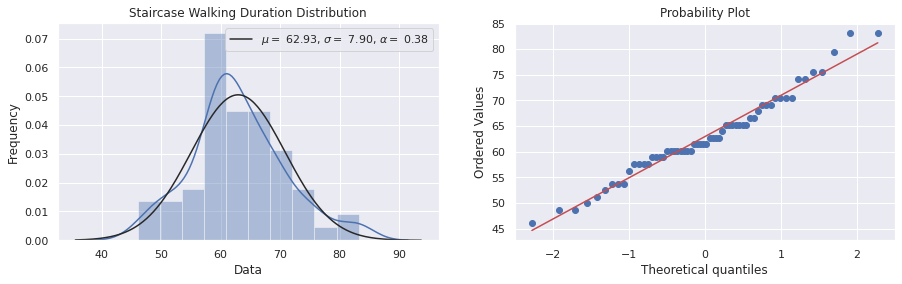

In [21]:
def plotSkew(x):
    # Fit label to norm
    (mu, sigma) = norm.fit(x)
    alpha = skew(x)

    fig, axarr = plt.subplots(1, 2, figsize=(15,4))

    # Plot label and fit
    sns.distplot(x , fit=norm, ax=axarr[0])
    axarr[0].legend(['$\mu=$ {:.2f}, $\sigma=$ {:.2f}, $\\alpha=$ {:.2f}'.format(mu, sigma, alpha)], loc='best')
    axarr[0].set_title('Staircase Walking Duration Distribution')
    axarr[0].set_ylabel('Frequency')

    # Plot probability plot
    res = probplot(x, plot=axarr[1])
    plt.show()
    
    
plotSkew(duration_df)

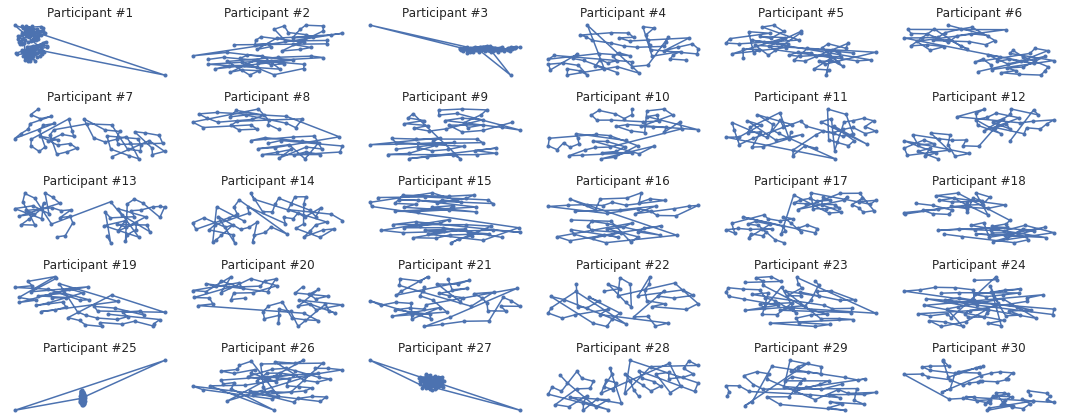

In [22]:
fig, axarr = plt.subplots(5, 6, figsize=(15,6))

for person in range(0, 30):
    # Get data
    single_person = both_df[(label=='WALKING') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    # Scale data
    scl = StandardScaler()
    tsne_data = scl.fit_transform(single_person)
    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    tsne_data = pca.fit_transform(tsne_data)
    # Transform data
    tsne = TSNE(random_state=3)
    tsne_transformed = tsne.fit_transform(tsne_data)
    
    # Create plot
    axarr[person//6][person%6].plot(tsne_transformed[:,0], tsne_transformed[:,1], '.-')
    axarr[person//6][person%6].set_title('Participant #{}'.format(person+1))
    axarr[person//6][person%6].axis('off')
    
plt.tight_layout()
plt.show()

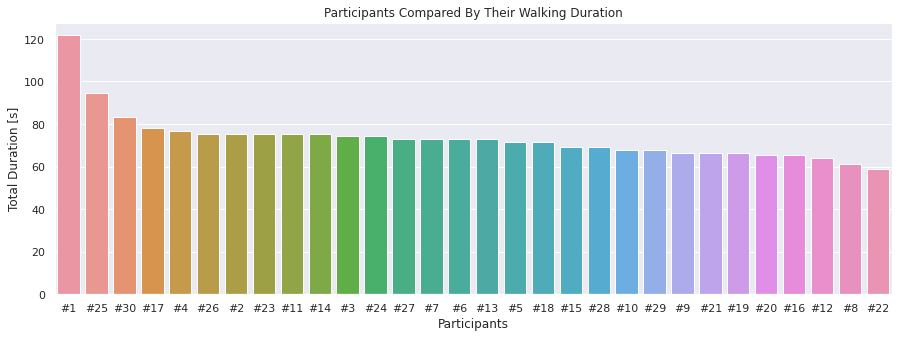

In [23]:
# Group the data by participant and compute total duration of walking
mask = label=='WALKING'
duration_df = (both_df[mask].groupby('subject')['Data'].count() * 1.28)

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data')
plt.title('Participants Compared By Their Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

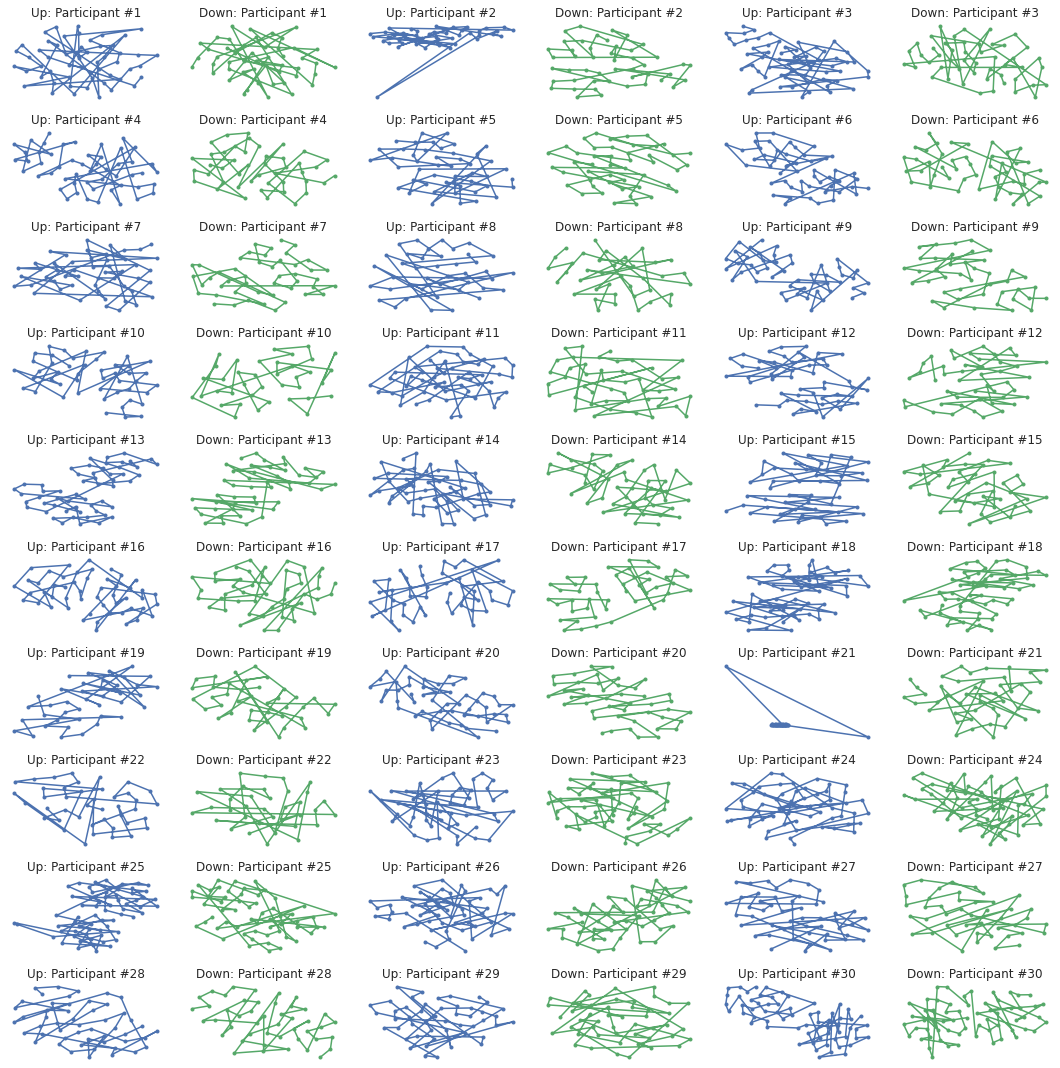

In [24]:
# Create subplots
fig, axarr = plt.subplots(10, 6, figsize=(15,15))

# Iterate over each participant
for person in range(0, 30):
    # Get data
    single_person_up = both_df[(label=='WALKING_UPSTAIRS') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    single_person_down = both_df[(label=='WALKING_DOWNSTAIRS') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    # Scale data
    scl = StandardScaler()
    tsne_data_up = scl.fit_transform(single_person_up)
    tsne_data_down = scl.fit_transform(single_person_down)
    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    tsne_data_up = pca.fit_transform(tsne_data_up)
    tsne_data_down = pca.fit_transform(tsne_data_down)
    # Transform data
    tsne = TSNE(random_state=3)
    tsne_transformed_up = tsne.fit_transform(tsne_data_up)
    tsne_transformed_down = tsne.fit_transform(tsne_data_down)
    
    # Create plot
    axarr[2*person//6][2*person%6].plot(tsne_transformed_up[:,0], tsne_transformed_up[:,1], '.b-')
    axarr[2*person//6][2*person%6].set_title('Up: Participant #{}'.format(person+1))
    axarr[2*person//6][2*person%6].axis('off')
    axarr[2*person//6][(2*person%6)+1].plot(tsne_transformed_down[:,0], tsne_transformed_down[:,1], '.g-')
    axarr[2*person//6][(2*person%6)+1].set_title('Down: Participant #{}'.format(person+1))
    axarr[2*person//6][(2*person%6)+1].axis('off')
    
plt.tight_layout()
plt.show()

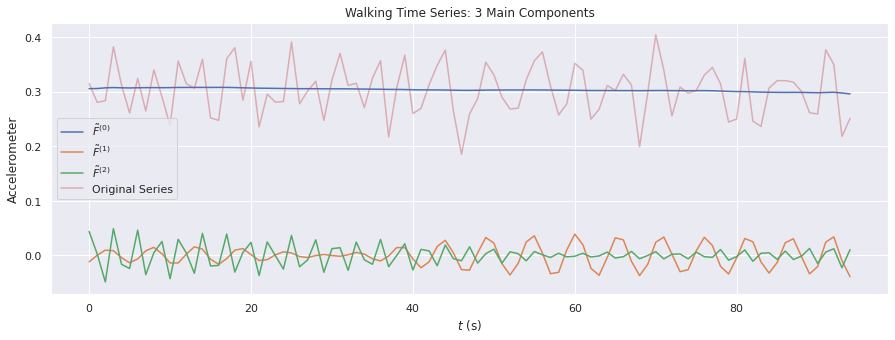

In [25]:
# Use SS class fro jdarcy
class SSA(object):    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        '''
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        '''
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError('Unsupported time series object. Try Pandas Series, NumPy array or list.')
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError('The window length must be in the interval [2, N/2].')
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = 'Re-run with save_mem=False to retain the elementary matrices.'
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = 'Re-run with save_mem=False to retain the V matrix.'
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        '''
        Returns all the time series components in a single Pandas DataFrame object.
        '''
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ['F{}'.format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        '''
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        '''
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        '''
        Calculates the w-correlation matrix for the time series.
        '''
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        '''
        Plots the w-correlation matrix for the decomposed time series.
        '''
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r'$\tilde{F}_i$')
        plt.ylabel(r'$\tilde{F}_j$')
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label('$W_{i,j}$')
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        
        
# Euclidean norm of the acceleration
walking_series = both_df[(label=='WALKING') & (both_df['subject']=='#1')][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop=True)
walking_series = (walking_series**2).sum(axis=1)**0.5

# Decomposing the series
series_ssa = SSA(walking_series, 30)

# Plotting the decomposition
plt.figure(figsize=(15,5))
series_ssa.reconstruct(0).plot()
series_ssa.reconstruct([1,2]).plot()
series_ssa.reconstruct([3,4]).plot()
series_ssa.orig_TS.plot(alpha=0.4)
plt.title('Walking Time Series: 3 Main Components')
plt.xlabel(r'$t$ (s)')
plt.ylabel('Accelerometer')
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(3)] + ['Original Series']
plt.legend(legend);

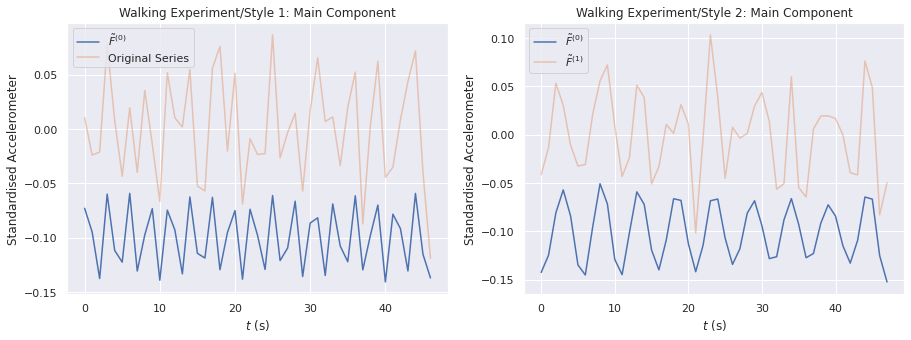

In [26]:
# Both walking styles from a single participant
style1 = both_df.loc[78:124][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop=True)
style1 = ((style1**2).sum(axis=1)**0.5)
style1 -= style1.mean()
style2 = both_df.loc[248:295][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop=True)
style2 = (style2**2).sum(axis=1)**0.5
style2 -= style2.mean()

# Decompose
style1_ssa = SSA(style1, 20)
style2_ssa = SSA(style2, 20)

# Create plot
fig, axarr = plt.subplots(1, 2, figsize=(15,5))

# Plotting the decomposition style 1
(style1_ssa.reconstruct([0,1])-0.1).plot(ax=axarr[0])
style1_ssa.orig_TS.plot(alpha=0.4, ax=axarr[0])
axarr[0].set_title('Walking Experiment/Style 1: Main Component')
axarr[0].set_xlabel(r'$t$ (s)')
axarr[0].set_ylabel('Standardised Accelerometer')
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(1)] + ['Original Series']
axarr[0].legend(legend);

# Plotting the decomposition style 2
(style2_ssa.reconstruct([0,1])-0.1).plot(ax=axarr[1])
style2_ssa.orig_TS.plot(alpha=0.4, ax=axarr[1])
axarr[1].set_title('Walking Experiment/Style 2: Main Component')
axarr[1].set_xlabel(r'$t$ (s)')
axarr[1].set_ylabel('Standardised Accelerometer')
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(3)] + ['Original Series']
axarr[1].legend(legend);

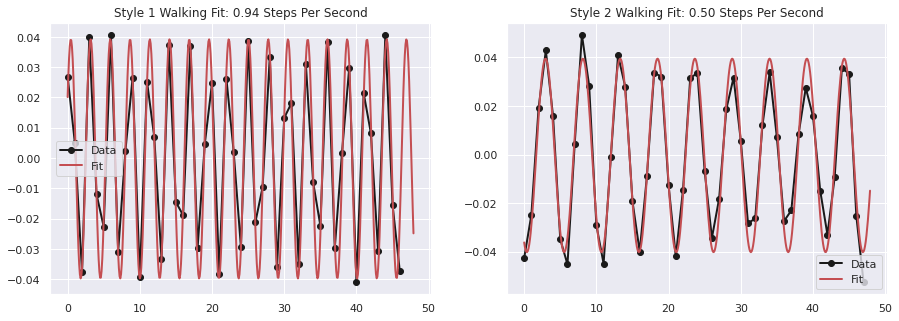

In [27]:
# Function to fit a sinus
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    # Assume uniform spacing
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))
    Fyy = abs(np.fft.fft(yy))
    # Exclude the zero frequency "peak"
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    # Sinus
    def sinfunc(t, A, w, p, c):  
        return A * np.sin(w*t + p) + c
    
    # Fit sinus
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

# Get data
main_style1 = style1_ssa.reconstruct([0, 1])
tt1 = main_style1.index
yy1 = main_style1.values
tt_res1 = np.arange(0, 48, 0.1)
# Fit data
res1 = fit_sin(tt1, yy1)

# Get data
main_style2 = style2_ssa.reconstruct([0, 1])
tt2 = main_style2.index
yy2 = main_style2.values
tt_res2 = np.arange(0, 48, 0.1)
# Fit data
res2 = fit_sin(tt2, yy2)

# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(15,5))

# Plot data
axarr[0].plot(tt1, yy1, "-ok", label='Data', linewidth=2)
axarr[0].plot(tt_res1, res1['fitfunc'](tt_res1), "r-", label='Fit', linewidth=2)
axarr[0].set_title('Style 1 Walking Fit: {:.2f} Steps Per Second'.format((res1['omega']*1.28)/(pi)))
axarr[0].legend(loc="best")

axarr[1].plot(tt2, yy2, "-ok", label='Data', linewidth=2)
axarr[1].plot(tt_res2, res2['fitfunc'](tt_res2), "r-", label='Fit', linewidth=2)
axarr[1].set_title('Style 2 Walking Fit: {:.2f} Steps Per Second'.format((res2['omega']*1.28)/(pi)))
axarr[1].legend(loc="best")
plt.show()

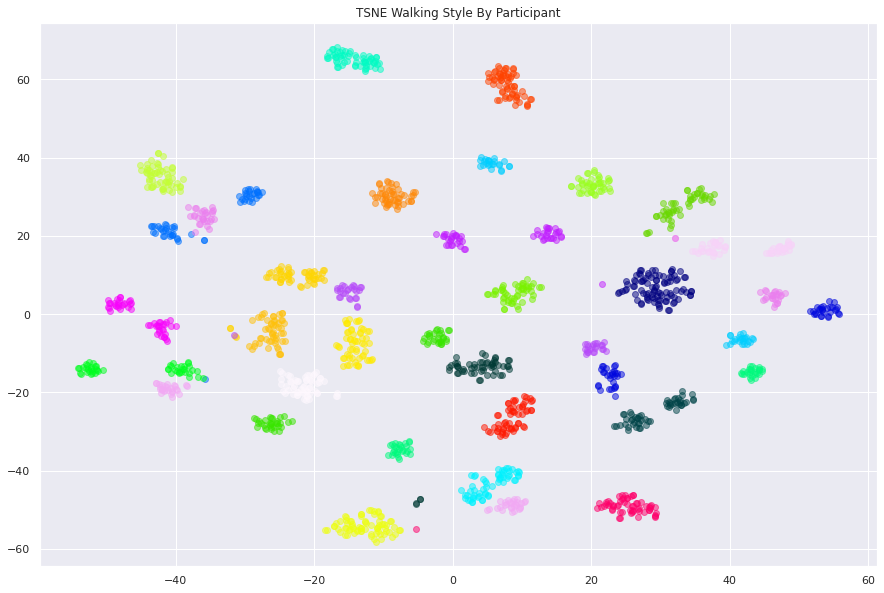

In [28]:
# Get data
tsne_data = both_df[label=='WALKING'].copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
fig, axarr = plt.subplots(1, 1, figsize=(15,10))

### Plot Subjects
# Get colors
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr.scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr.set_title('TSNE Walking Style By Participant')
plt.show()

**Feature Scaling**


**Pre-processing and data preparation to feed data into Artificial Neural Network.**

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df.iloc[:,0:562])
mat_train = scaler.transform(train_df.iloc[:,0:562])
print(mat_train)

[[0.64429225 0.48985291 0.43354743 ... 0.79825103 0.47068654 0.        ]
 [0.63920942 0.49179472 0.4382399  ... 0.79848665 0.47284164 0.        ]
 [0.63982653 0.49026642 0.44326915 ... 0.79872236 0.47544109 0.        ]
 ...
 [0.63669369 0.49149469 0.47748909 ... 0.84506893 0.52040559 1.        ]
 [0.64482708 0.49057848 0.42085971 ... 0.84323381 0.51266974 1.        ]
 [0.67575173 0.49378844 0.39806642 ... 0.84348837 0.51834742 1.        ]]


In [30]:
scaler = MinMaxScaler()
scaler.fit(test_df.iloc[:,0:562])
mat_test = scaler.transform(test_df.iloc[:,0:562])
print(mat_test)

[[0.6718788  0.55764282 0.52464834 ... 0.62209457 0.46362736 0.        ]
 [0.69470427 0.57426358 0.42707858 ... 0.62446791 0.45014396 0.        ]
 [0.68636345 0.55310221 0.42794829 ... 0.62380956 0.45251181 0.        ]
 ...
 [0.74529355 0.64526771 0.43015674 ... 0.62088108 0.58803909 1.        ]
 [0.65638384 0.62620241 0.44817885 ... 0.61581385 0.59135763 1.        ]
 [0.58994885 0.56560474 0.41032069 ... 0.61537208 0.59163879 1.        ]]


In [31]:
temp = []
for i in train_df.Activity:
    if i == "WALKING": temp.append(0)
    if i == "WALKING_UPSTAIRS": temp.append(1)
    if i == "WALKING_DOWNSTAIRS": temp.append(2)
    if i == "SITTING": temp.append(3)
    if i == "STANDING": temp.append(4)
    if i == "LAYING": temp.append(5)
train_df["n_Activity"] = temp

In [32]:
temp = []
for i in test_df.Activity:
    if i == "WALKING": temp.append(0)
    if i == "WALKING_UPSTAIRS": temp.append(1)
    if i == "WALKING_DOWNSTAIRS": temp.append(2)
    if i == "SITTING": temp.append(3)
    if i == "STANDING": temp.append(4)
    if i == "LAYING": temp.append(5)
test_df["n_Activity"] = temp

In [33]:
train_df.drop(["Activity"] , axis = 1 , inplace = True)

In [34]:
test_df.drop(["Activity"] , axis = 1 , inplace = True)

In [35]:
from keras.utils import to_categorical
y_train = to_categorical(train_df.n_Activity , num_classes=6)
y_test = to_categorical(test_df.n_Activity , num_classes=6)

In [36]:
X_train = mat_train 
X_test = mat_test

In [37]:
print(X_train.shape , y_train.shape)
print(X_test.shape , y_test.shape)

(7352, 562) (7352, 6)
(2947, 562) (2947, 6)
